# Нейронная сеть для задачи регрессии
### Модуль 3.5
Хотим сделать сеть, которая будет предсказывать функцию y=sin(x)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)

In [3]:
import torch

# Train dataset

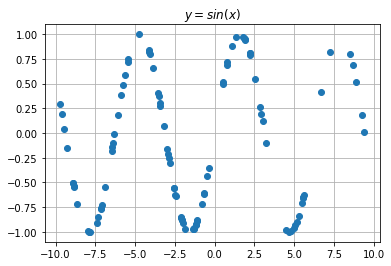

In [4]:
# Наша обучающая выборка. Мы взяли 100 случайных точек из равномерного распределения о 0 до 1,
# умножаем их на 20 и отнимаем 10, чтобы график был выровнен по центру
x_train = torch.rand(100)
x_train = x_train * 20.0 - 10.0

# От всех значений берем синус
y_train = torch.sin(x_train)

# Получившийся рисунок - наша обучающая выборка. По ней нам надо восстановить всю функцию
plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.grid()
plt.title('$y=sin(x)$');

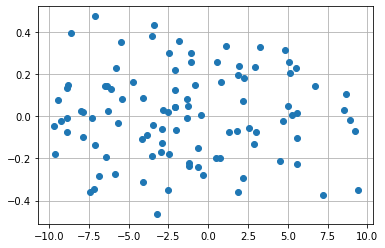

In [5]:
# Пусть имеется шум из нормального расределения, примерно такой как на картинке
noise = torch.randn(y_train.shape) / 5.

plt.grid()
plt.plot(x_train.numpy(), noise.numpy(), 'o');

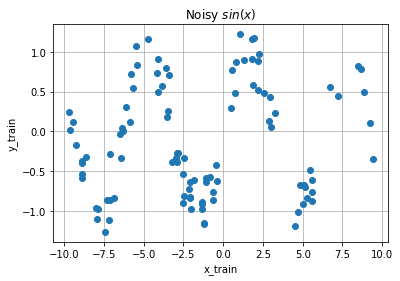

In [6]:
# Добавим шум к нашим данным. Это похоже на реальные данные, по которым нужно что-то предсказывать
y_train = y_train + noise
plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('Noisy $sin(x)$')
plt.grid()
plt.xlabel('x_train')
plt.ylabel('y_train');

### Сможет ли нейросеть разобраться, что тут функция синус, а что - какой-то шум?

In [7]:
# Когда мы передаём в нейросеть данные - нам хочется, чтобы они были правильной размерности
x_train.unsqueeze_(1) # если есть "_" - то он трансформирует метод, к которому он применяется
y_train.unsqueeze_(1)


# Пример для методы unsqueeze
tmp = torch.Tensor([1, 2, 3])
print(tmp)
# Превращает строчку в стобец, где в каждой строчке будет одно число. 
# 1 в скобочках - это значит, что превращаем в столбец
print(tmp.unsqueeze_(1))

tensor([1., 2., 3.])
tensor([[1.],
        [2.],
        [3.]])


# Validation dataset

Валидационный датасет пусть просто будет функция синуса, без шумов.

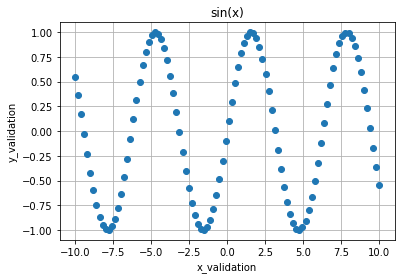

In [8]:
x_validation = torch.linspace(-10, 10, 100)
y_validation = torch.sin(x_validation.data)
plt.plot(x_validation.numpy(), y_validation.numpy(), 'o')
plt.title('sin(x)')
plt.grid()
plt.xlabel('x_validation')
plt.ylabel('y_validation');

In [9]:
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1);

# Model construction
Создаём нейронную сеть

In [10]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        # Принимает на вход любые параметры, которые нам будет интересно 
        # передать в эту сеть в момент конструирования.
        
        # Например, нам интересно передать количество скрытых нейронов,
        # которые будут храниться в каждом слое
        super(SineNet, self).__init__()   # инициализируем родительский объект (для наследования)
        # Давайте создавать слои
        # fc = fully-connected layer, в pytorch он называется Linear
        # Передаем 1 входной нейрон (точка в одномерном пространстве; если, например, точка была бы в
        # многомерном пространстве, то размерность того пространства, в котором задаю точку).
        # Выходных нейронов (по количеству) будет n_hidden_nurons.
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        # функция активации
        self.act1 = torch.nn.Sigmoid()
        # Добавим еще один полносвязный слой с одним выходным нейроном:
        # этот нейрон будет нашим ответом на вопрос: так как нас интересует на выходе в
        # качестве ответа одно число, то на выходе будет один нейрон
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)
        
        
        # В итоге в нейросети будет 2 слоя: в первом будет несколько нейронов, а во 2ом будет 1 нейрон.
    
    def forward(self, x):
        """
        То, как наши слои последовательно применяются
        По сути эта функция повторяет нашу инициализацию
        """
        
        # Сначала применяем слой fc1
        x = self.fc1(x)
        # То, что получилось - передаём в функцию активации
        x = self.act1(x)
        x = self.fc2(x)
        return x


# Количество скрытых нейронов = 50
sine_net = SineNet(50)

        
    

В итоге в нейросети будет 2 слоя: в первом будет несколько нейронов, а во втором будет один нейрон.

# Prediction

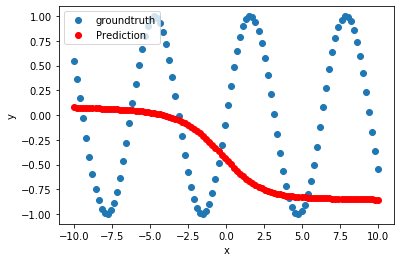

In [12]:
def predict(net, x, y):
    y_pred = net.forward(x)   # вызов метода forward: передаем х --> получаем prediction
    
    plt.plot(x.numpy(), y.numpy(), 'o', label='groundtruth')   # то, что МЫ БЫ ХОТЕЛИ на валидации увидеть
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction')   # то, что сеть нам предсказала
    plt.legend(loc='upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    

predict(sine_net, x_validation, y_validation)

# ДАВАЙТЕ ОБУЧИМ НЕЙРОСЕТЬ

Для этого потребуется:
## 1. Optimizer
Adam - это вариация оптимизатора наподобие SGD, просто SGD плохо работает для данной задачи.
Это объект, который будет совершать для нас шаги градиентного спуска.
**На вход к Adam'у передаются те параметры, которые мы хотим обучать: это не иксы, потому что 
на сами точки мы не можем никак повлиять, НО МЫ МОЖЕМ ПОВЛИЯТЬ НА ВЕСА, их и передаем** (sine_net.parameters)

In [14]:
optimizer = torch.optim.SGD(sine_net.parameters(), lr=0.01)

## 2. Loss function

Та функция, которая нам говорит, насколько неправильно мы предсказали и на сколько мы ошиблись. Эта функция будет участвовать в градиентном спуске.

In [15]:
def loss(pred, target):
    squares = (pred-target) ** 2
    return squares.mean()

## 3. Training procedure

**ЭПОХА:**    
Возьмём датасет --> прогоним его через нейросеть --> получим некоторые предсказания --> на предсказаниях посчитаем функцию потерь --> посчитаем производную, сделаем градиентный шаг.

1 ЭПОХА = 1 раз просмотрели весь датасет.    
Может потребоваться много эпох.    



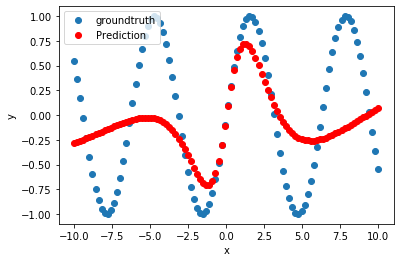

In [18]:
for epoch_index in range(2000):
    # ВНУТРИ ОДНОЙ ЭПОХИ
    optimizer.zero_grad()   # зануляем градиенты!!!
    
    # Считаем предскзаание нейросети
    y_pred = sine_net.forward(x_train)
    # Счиатем функцию потерь, получаем число (скаляр)
    loss_val = loss(y_pred, y_train)
    
    # просчет обратного распространения ошибки, чтобы сделать шаг градиентного спуска
    loss_val.backward()  # параметр, который зависит от весов нейросети
    
    optimizer.step()


predict(sine_net, x_validation, y_validation)